<a href="https://colab.research.google.com/github/Deeksha-Pandit/EVA4-S9/blob/master/S9_backup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline


In [2]:
!pip install -U git+https://github.com/albu/albumentations


  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-cplnnkbz
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-cplnnkbz
     |████████████████████████████████| 634kB 8.5MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=64514 sha256=46fba8682762a188e25429b06535cab01540a7d437314a41012e8393651e58a6
  Stored in directory: /tmp/pip-ephem-wheel-cache-h16i08cz/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=c2b160ceb2fae49a34bb22c9a6cfc21d1396bb634acc5e4ee0b6e7b2252aa5fa
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
  


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [3]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import sys
folder = '/content/gdrive/My Drive/Session9'
sys.path.append(folder)

In [0]:
import torch
import Albumentation
import show_images
import my_model
import train_test
import evaluate
import GradCam
#from GradCam import GradCAM,visualize_cam

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [6]:
classes, trainloader, testloader = Albumentation.album_Compose.load()

CUDA Available? True


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some of the training images, for fun.



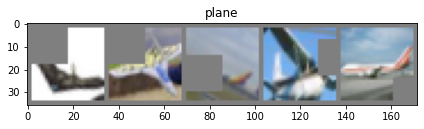

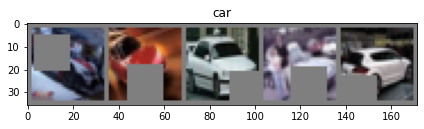

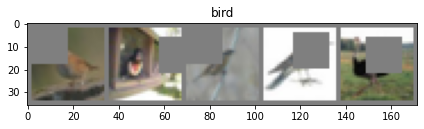

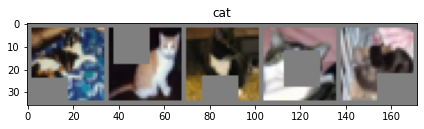

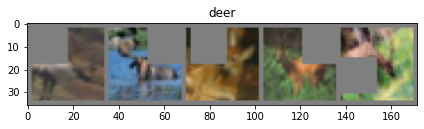

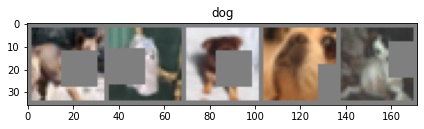

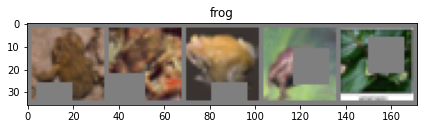

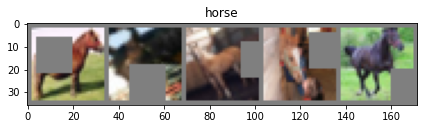

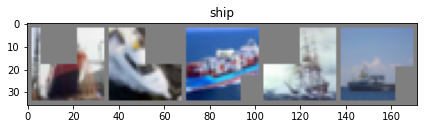

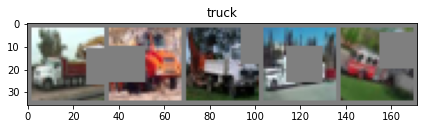

In [7]:
show_images.show_random_images(trainloader, classes)

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
resnet = my_model.ResNet18().to(device)
summary(resnet, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)
scheduler = StepLR(optimizer, step_size=8, gamma=0.1)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [10]:
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train_test.train(resnet, device, trainloader, optimizer, criterion, epoch)
    train_test.test(resnet, device, criterion, testloader)


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.2694456577301025 Batch_id=390 Accuracy=43.41: 100%|██████████| 391/391 [00:59<00:00,  6.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0100, Accuracy: 5582/10000 (55.82%)

EPOCH: 2


Loss=1.4133447408676147 Batch_id=390 Accuracy=58.42: 100%|██████████| 391/391 [01:01<00:00,  6.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0073, Accuracy: 6856/10000 (68.56%)

EPOCH: 3


Loss=0.8810526132583618 Batch_id=390 Accuracy=64.99: 100%|██████████| 391/391 [01:01<00:00,  6.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 7195/10000 (71.95%)

EPOCH: 4


Loss=0.8585789799690247 Batch_id=390 Accuracy=68.61: 100%|██████████| 391/391 [01:00<00:00,  6.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0069, Accuracy: 7026/10000 (70.26%)

EPOCH: 5


Loss=0.6961129903793335 Batch_id=390 Accuracy=70.91: 100%|██████████| 391/391 [01:01<00:00,  6.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0068, Accuracy: 6993/10000 (69.93%)

EPOCH: 6


Loss=0.6509155631065369 Batch_id=390 Accuracy=72.05: 100%|██████████| 391/391 [01:00<00:00,  6.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 7545/10000 (75.45%)

EPOCH: 7


Loss=0.8370601534843445 Batch_id=390 Accuracy=73.55: 100%|██████████| 391/391 [01:00<00:00,  6.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 7846/10000 (78.46%)

EPOCH: 8


Loss=0.7430052757263184 Batch_id=390 Accuracy=74.54: 100%|██████████| 391/391 [01:01<00:00,  6.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 7565/10000 (75.65%)

EPOCH: 9


Loss=0.8235581517219543 Batch_id=390 Accuracy=75.41: 100%|██████████| 391/391 [01:00<00:00,  6.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 7576/10000 (75.76%)

EPOCH: 10


Loss=0.7839548587799072 Batch_id=390 Accuracy=76.23: 100%|██████████| 391/391 [01:01<00:00,  6.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8060/10000 (80.60%)

EPOCH: 11


Loss=0.6585636734962463 Batch_id=390 Accuracy=76.57: 100%|██████████| 391/391 [01:00<00:00,  6.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8226/10000 (82.26%)

EPOCH: 12


Loss=0.6887719631195068 Batch_id=390 Accuracy=77.43: 100%|██████████| 391/391 [01:00<00:00,  6.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8217/10000 (82.17%)

EPOCH: 13


Loss=0.7257274389266968 Batch_id=390 Accuracy=77.08: 100%|██████████| 391/391 [01:00<00:00,  6.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 7755/10000 (77.55%)

EPOCH: 14


Loss=0.9784595370292664 Batch_id=390 Accuracy=77.52: 100%|██████████| 391/391 [01:00<00:00,  6.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0085, Accuracy: 6650/10000 (66.50%)

EPOCH: 15


Loss=0.5364090800285339 Batch_id=390 Accuracy=77.92: 100%|██████████| 391/391 [01:00<00:00,  6.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 7937/10000 (79.37%)

EPOCH: 16


Loss=0.4857831597328186 Batch_id=390 Accuracy=77.87: 100%|██████████| 391/391 [01:00<00:00,  6.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 7868/10000 (78.68%)

EPOCH: 17


Loss=0.5210680961608887 Batch_id=390 Accuracy=78.32: 100%|██████████| 391/391 [01:00<00:00,  6.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 7991/10000 (79.91%)

EPOCH: 18


Loss=0.6742869019508362 Batch_id=390 Accuracy=78.31: 100%|██████████| 391/391 [01:01<00:00,  6.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8122/10000 (81.22%)

EPOCH: 19


Loss=0.7269995212554932 Batch_id=390 Accuracy=78.68: 100%|██████████| 391/391 [01:00<00:00,  6.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8104/10000 (81.04%)

EPOCH: 20


Loss=0.6089300513267517 Batch_id=390 Accuracy=78.92: 100%|██████████| 391/391 [01:01<00:00,  6.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 7866/10000 (78.66%)

EPOCH: 21


Loss=0.7821189761161804 Batch_id=390 Accuracy=79.07: 100%|██████████| 391/391 [01:00<00:00,  6.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8010/10000 (80.10%)

EPOCH: 22


Loss=0.6381686925888062 Batch_id=390 Accuracy=79.22: 100%|██████████| 391/391 [01:00<00:00,  6.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8151/10000 (81.51%)

EPOCH: 23


Loss=0.5996996760368347 Batch_id=390 Accuracy=79.40: 100%|██████████| 391/391 [01:00<00:00,  6.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8305/10000 (83.05%)

EPOCH: 24


Loss=0.6636444330215454 Batch_id=390 Accuracy=79.51: 100%|██████████| 391/391 [01:00<00:00,  6.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8155/10000 (81.55%)

EPOCH: 25


Loss=0.6489327549934387 Batch_id=390 Accuracy=79.70: 100%|██████████| 391/391 [01:00<00:00,  6.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8295/10000 (82.95%)

EPOCH: 26


Loss=0.5354709029197693 Batch_id=390 Accuracy=80.25: 100%|██████████| 391/391 [01:00<00:00,  6.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8375/10000 (83.75%)

EPOCH: 27


Loss=0.6792723536491394 Batch_id=390 Accuracy=79.77: 100%|██████████| 391/391 [01:00<00:00,  6.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8527/10000 (85.27%)

EPOCH: 28


Loss=0.5294715166091919 Batch_id=390 Accuracy=80.28: 100%|██████████| 391/391 [01:00<00:00,  6.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8524/10000 (85.24%)

EPOCH: 29


Loss=0.4899062514305115 Batch_id=390 Accuracy=79.91: 100%|██████████| 391/391 [01:00<00:00,  6.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8047/10000 (80.47%)

EPOCH: 30


Loss=0.7645214200019836 Batch_id=390 Accuracy=80.24: 100%|██████████| 391/391 [01:00<00:00,  6.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8415/10000 (84.15%)

EPOCH: 31


Loss=0.6120573282241821 Batch_id=390 Accuracy=80.13: 100%|██████████| 391/391 [01:00<00:00,  6.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 7839/10000 (78.39%)

EPOCH: 32


Loss=0.44643887877464294 Batch_id=390 Accuracy=80.42: 100%|██████████| 391/391 [01:00<00:00,  6.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8532/10000 (85.32%)

EPOCH: 33


Loss=0.4489031434059143 Batch_id=390 Accuracy=80.60: 100%|██████████| 391/391 [01:00<00:00,  6.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 7991/10000 (79.91%)

EPOCH: 34


Loss=0.5962262153625488 Batch_id=390 Accuracy=80.59: 100%|██████████| 391/391 [01:00<00:00,  6.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8157/10000 (81.57%)

EPOCH: 35


Loss=0.694692850112915 Batch_id=390 Accuracy=80.89: 100%|██████████| 391/391 [01:00<00:00,  6.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8513/10000 (85.13%)

EPOCH: 36


Loss=0.7222192883491516 Batch_id=390 Accuracy=80.83: 100%|██████████| 391/391 [01:00<00:00,  6.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8467/10000 (84.67%)

EPOCH: 37


Loss=0.47415104508399963 Batch_id=390 Accuracy=80.80: 100%|██████████| 391/391 [01:00<00:00,  6.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8362/10000 (83.62%)

EPOCH: 38


Loss=0.6194463968276978 Batch_id=390 Accuracy=80.77: 100%|██████████| 391/391 [01:00<00:00,  6.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8336/10000 (83.36%)

EPOCH: 39


Loss=0.6180142760276794 Batch_id=390 Accuracy=80.98: 100%|██████████| 391/391 [01:00<00:00,  6.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8382/10000 (83.82%)

EPOCH: 40


Loss=0.5784795880317688 Batch_id=390 Accuracy=81.07: 100%|██████████| 391/391 [01:00<00:00,  6.46it/s]



Test set: Average loss: 0.0036, Accuracy: 8503/10000 (85.03%)



5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



GroundTruth:   frog plane   cat horse
Predicted:   frog plane horse horse


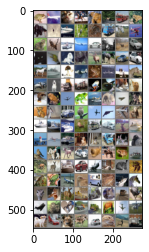

In [12]:
evaluate.show_predicted_actual(resnet, device, testloader, classes)


Okay, now let us see what the neural network thinks these examples above are:



The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [13]:
evaluate.evaluate_accuracy(resnet, device, testloader)

Accuracy of the network on the 10000 test images: 68.990 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [14]:
evaluate.evaluate_classwise_accuracy(resnet, device, classes, testloader)

Accuracy of plane : 83 %
Accuracy of   car : 90 %
Accuracy of  bird : 81 %
Accuracy of   cat : 50 %
Accuracy of  deer : 60 %
Accuracy of   dog : 55 %
Accuracy of  frog : 29 %
Accuracy of horse : 77 %
Accuracy of  ship : 74 %
Accuracy of truck : 58 %


In [0]:
#from GradCam import GradCAM,visualize_cam

import PIL
img_name =[sys.path[-1]+'/plane.jpg',sys.path[-1]+'/car.jpg',sys.path[-1]+'/bird.jpg',sys.path[-1]+'/cat.jpg',sys.path[-1]+'/deer.jpg',sys.path[-1]+'/dog.jpg',sys.path[-1]+'/frog.jpg',sys.path[-1]+'/horse.jpg',sys.path[-1]+'/ship.jfif',sys.path[-1]+'/truck.jpg',]
#img_path = sys.path[-1]+img_name

pil_image = []
for i,img in enumerate(img_name):
   pil_image.append(PIL.Image.open(img))
#pil_img = PIL.Image.open(img_path)
#pil_img

In [0]:
from torchvision import transforms
normed_torch_img = []
torch_img_list = []

for i in pil_image:
  torch_img = transforms.Compose([
      transforms.Resize((32, 32)),
      transforms.ToTensor()
  ])(i).to(device)
  torch_img_list.append(torch_img)

  normed_torch_img .append(transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])(torch_img)[None])

In [0]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(img,c="" ):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig = plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)),interpolation='none')
    plt.title(c)

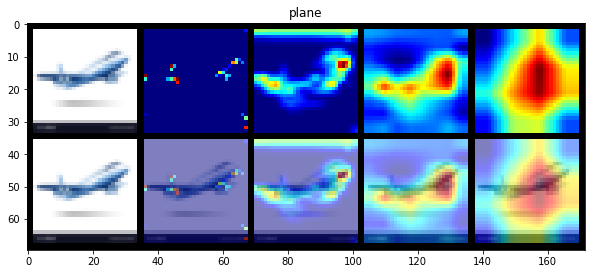

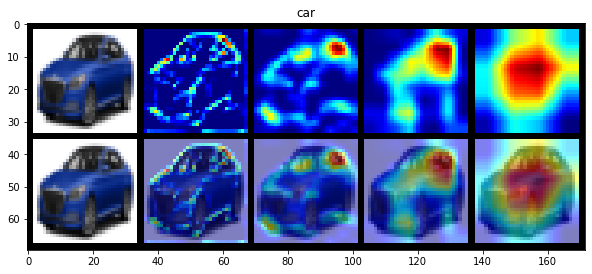

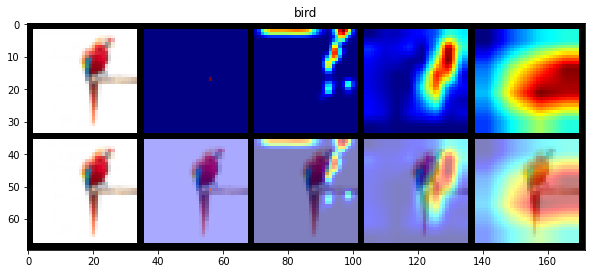

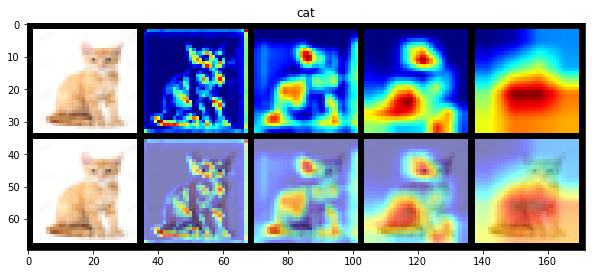

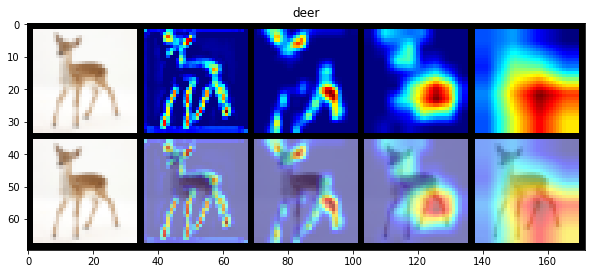

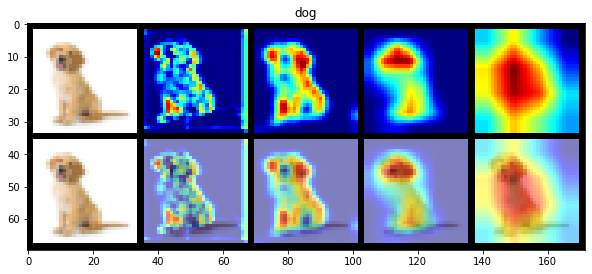

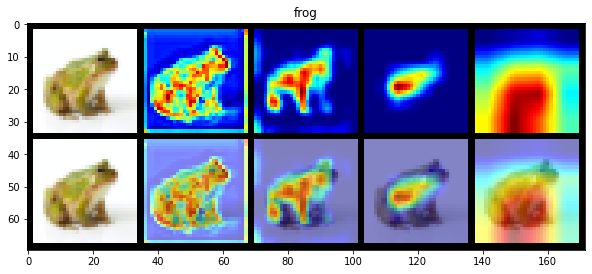

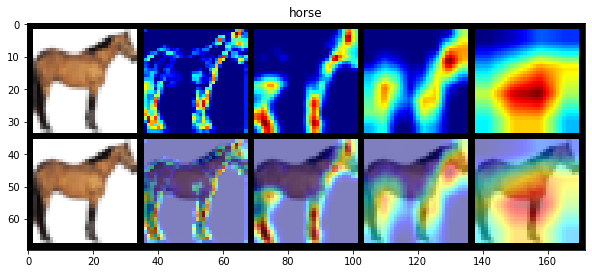

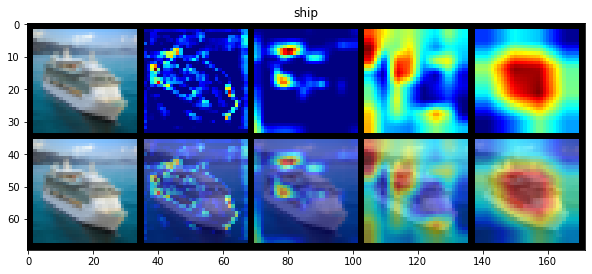

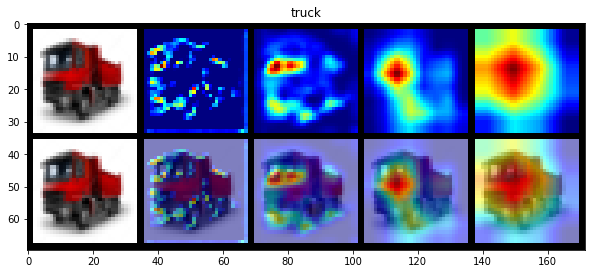

In [18]:
import copy
from torchvision.utils import make_grid, save_image

for i,k in enumerate(normed_torch_img):
  images1 = [torch_img_list[i].cpu()]
  images2 =  [torch_img_list[i].cpu()]
  b = copy.deepcopy(resnet.to(device))
  layers =  [b.layer1,b.layer2,b.layer3,b.layer4]
  for j in layers:
    g = GradCAM(b,j)
    mask, _= g(normed_torch_img[i])
    heatmap, result = GradCam.GradCAM.visualize_cam(mask,torch_img_list[i] )
    images1.extend([heatmap])
    images2.extend([result])
  grid_image = make_grid(images1+images2, nrow=5)
  imshow(grid_image,classes[i])